In [1]:
# define a function to check for successful installation of the libraries
def lib_installation_check(captured_data, n_lines_print):
    """
    A function to use the %%capture output from the cells where we try to install the libraries.
    It would print last "n_lines_print" if there is an error in library installation
    """
    output_text = captured_data.stdout
    lines = output_text.splitlines()
    output_last_n_lines = '\n'.join(lines[-n_lines_print:])
    if "error" in output_last_n_lines.lower():
        print("Library installation failed!")
        print("--- Error Details ---")
        print(output_last_n_lines)
    else:
        print("Library installation was successful, let's proceed ahead")

In [2]:
%%time
%%capture captured_output
%pip install scikit-learn==1.7.0 numpy==1.26 matplotlib==3.9.2
%pip install torch==2.8.0+cpu torchvision==0.23.0+cpu torchaudio==2.8.0+cpu \
    --index-url https://download.pytorch.org/whl/cpu
!pip install skillsnetwork

CPU times: user 4.68 s, sys: 653 ms, total: 5.33 s
Wall time: 1min 20s


In [3]:
lib_installation_check(captured_data = captured_output, n_lines_print = 5)

Library installation was successful, let's proceed ahead


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import os
import sys
import time
import shutil
import random
import numpy as np
import skillsnetwork
from tqdm import tqdm
import matplotlib.pyplot as plt

In [1]:
!pip install --upgrade numpy

In [2]:
%%time
# --- AI LIBRARY IMPORTS ---
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Imported libraries")

Imported libraries
CPU times: user 5.07 s, sys: 629 ms, total: 5.7 s
Wall time: 8.37 s


In [3]:
extract_dir = "."


In [4]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4Z1fwRR295-1O3PMQBH6Dg/images-dataSAT.tar"

In [8]:
def check_skillnetwork_extraction(extract_dir):
    """ function to check whether data download and extraction method
    `skillsnetwork.prepare` would execute successfully, without downloading any data.
    This helps in early detection and fast fallback to explicit download and extraction
    using default libraries
    ###This is a hack for the code to run on non-cloud computing environment without errors
    """
    symlink_test = os.path.join(extract_dir, "symlink_test")
    if not os.path.exists(symlink_test):
        os.symlink(os.path.join(os.sep, "tmp"), symlink_test)
        print("Write permissions available for downloading and extracting the dataset tar file")
    os.unlink(symlink_test)

async def download_tar_dataset(url, tar_path, extract_dir):
    """function to explicitly download and extract the dataset tar file from cloud using native python libraries
    """
    if not os.path.exists(tar_path): # download only if file not downloaded already
        try:
            print(f"Downloading from {url}...")
            async with httpx.AsyncClient() as client:
                response = await client.get(url, follow_redirects=True)# Download the file asynchronously
                response.raise_for_status() # Raise an exception for bad status codes (4xx or 5xx)

                with open(tar_path , "wb") as f:
                    f.write(response.content) # Save the downloaded file
                print(f"Successfully downloaded '{file_name}'.")
        except httpx.HTTPStatusError as http_err:
            print(f"HTTP error occurred during download: {http_err}")
        except Exception as download_err:
            print(f"An error occurred during the fallback process: {download_err}")
    else:
        print(f"dataset tar file already downloaded at: {tar_path}")
    with tarfile.open(tar_path, 'r:*') as tar_ref:
        tar_ref.extractall(path=extract_dir)
    print(f"Successfully extracted to '{extract_dir}'.")



In [9]:
try:
    check_skillnetwork_extraction(extract_dir)
    await skillsnetwork.prepare(url = url, path = extract_dir, overwrite = True)
except Exception as e:
    print(e)
    # --- FALLBACK METHOD FOR DOWNLOADING THE DATA ---
    print("Primary download/extration method failed.")
    print("Falling back to manual download and extraction...")

    # import libraries required for downloading and extraction
    import tarfile
    import httpx
    from pathlib import Path

    file_name = Path(url).name# Get the filename from the URL (e.g., 'data.tar')
    tar_path = os.path.join(extract_dir, file_name)
    print(f"tar_path: {os.path.exists(tar_path)} ___ {tar_path}")
    await download_tar_dataset(url, tar_path, extract_dir)

Write permissions available for downloading and extracting the dataset tar file


  0%|          | 0/6003 [00:00<?, ?it/s]

Saved to '.'


In [10]:
## Random initialization, each neuron starts differently, enabling effective learning and convergence.


def set_seed(seed: int = 42) -> None:
    """Seed Python, NumPy, and PyTorch (CPU & all GPUs) and
    make cuDNN run in deterministic mode."""
    # ---- Python and NumPy -------------------------------------------
    random.seed(seed)
    np.random.seed(seed)

    # ---- PyTorch (CPU  &  GPU) --------------------------------------
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # ---- cuDNN: force repeatable convolutions -----------------------
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

In [22]:
SEED = 42

In [23]:
def worker_init_fn(worker_id: int) -> None:
    """Re-seed each DataLoader worker so their RNGs don't collide."""
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)

In [24]:
## Defining dataset_path
dataset_path = os.path.join(extract_dir, "images_dataSAT")
print(dataset_path)

./images_dataSAT


In [25]:
## Defining hyperparameters and device

img_size = 64
batch_size = 128
lr = 0.001
epochs = 3 # set to low number for your convenience. You can change this to any number of your liking
model_name = "ai_capstone_pytorch_state_dict.pth"
num_classes = 2 #number of classes in the dataset

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device used is {device}")


Device used is cpu


In [26]:
## Training and validation transformation pipeline

train_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                      transforms.RandomRotation(40),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

val_transform = transforms.Compose([
                                    transforms.Resize((img_size, img_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])

In [27]:
## Loading dataset
full_dataset = datasets.ImageFolder(dataset_path, transform=train_transform)

In [29]:
## Dataset split

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform

In [30]:
## Training and validation dataLoader

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4,
                          worker_init_fn=worker_init_fn
                         )

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=4,
                        worker_init_fn=worker_init_fn
                       )

In [31]:
## Defining the model

model = nn.Sequential(
                        # Conv Block 1
                        nn.Conv2d(3, 32, 5, padding=2), nn.ReLU(),
                        nn.MaxPool2d(2), nn.BatchNorm2d(32),

                        # Conv Block 2-6
                        nn.Conv2d(32, 64, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(64),
                        nn.Conv2d(64, 128, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(128),
                        nn.Conv2d(128, 256, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(256),
                        nn.Conv2d(256, 512, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(512),
                        nn.Conv2d(512, 1024, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(1024),

                        # Classifier
                        nn.AdaptiveAvgPool2d(1), nn.Flatten(),
                        nn.Linear(1024, 2048), nn.ReLU(), nn.BatchNorm1d(2048), nn.Dropout(0.4),
                        nn.Linear(2048, num_classes)
                    ).to(device)

In [32]:
## Defining the training setup


#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
best_loss = float('inf')
loss_history = {'train': [], 'val': []}
acc_history = {'train': [], 'val': []}

print("Created Model. Now training the model...")

Created Model. Now training the model...


In [33]:
## Training and validation

print(f"Training on : ==={device}=== with batch size: {batch_size} & lr: {lr}")

# --- TRAINING LOOP ---
for epoch in range(epochs):
    # Training Phase
    start_time = time.time() # to get the training time for each epoch
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0  # for the training metrics
    for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
        images, labels = images.to(device), labels.to(device)  # labels as integer class indices
        optimizer.zero_grad()
        outputs = model(images)  # outputs are raw logits
        loss = criterion(outputs, labels)  # criterion is nn.CrossEntropyLoss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    # Synchronize CUDA before stopping timer (if using GPU)
    if device == 'cuda':
        torch.cuda.synchronize()

    # Validation Phase
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0 #  for the validation metrics
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    # Save the best model
    avg_val_loss = val_loss/len(val_loader)
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), model_name)

    # Store metrics
    loss_history['train'].append(train_loss/len(train_loader))
    loss_history['val'].append(val_loss/len(val_loader))
    acc_history['train'].append(train_correct/train_total)
    acc_history['val'].append(val_correct/val_total)

    #print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {loss_history['train'][-1]:.4f} | Val Loss: {loss_history['val'][-1]:.4f}")
    print(f"Train Acc: {acc_history['train'][-1]:.4f} | Val Acc: {acc_history['val'][-1]:.4f}")
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1} training completed in {epoch_time:.2f} seconds\n")

print("Trained Model. Now evaluating the model...")

Training on : ===cpu=== with batch size: 128 & lr: 0.001


Epoch 1/3: 100%|██████████| 38/38 [03:23<00:00,  5.35s/it]


Train Loss: 0.2534 | Val Loss: 0.2621
Train Acc: 0.9475 | Val Acc: 0.9317
Epoch 1 training completed in 219.01 seconds



Epoch 2/3: 100%|██████████| 38/38 [03:24<00:00,  5.39s/it]


Train Loss: 0.0469 | Val Loss: 0.0614
Train Acc: 0.9831 | Val Acc: 0.9825
Epoch 2 training completed in 219.60 seconds



Epoch 3/3: 100%|██████████| 38/38 [03:21<00:00,  5.29s/it]


Train Loss: 0.0201 | Val Loss: 0.0170
Train Acc: 0.9942 | Val Acc: 0.9908
Epoch 3 training completed in 216.98 seconds

Trained Model. Now evaluating the model...


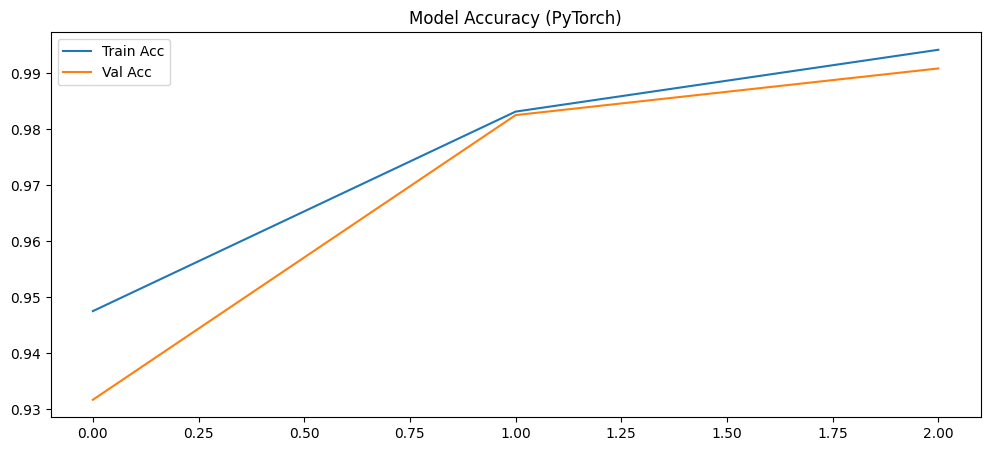

In [34]:
plt.figure(figsize=(12, 5))
plt.plot(acc_history['train'], label='Train Acc')
plt.plot(acc_history['val'], label='Val Acc')
plt.title('Model Accuracy (PyTorch)')
plt.legend()
plt.show()

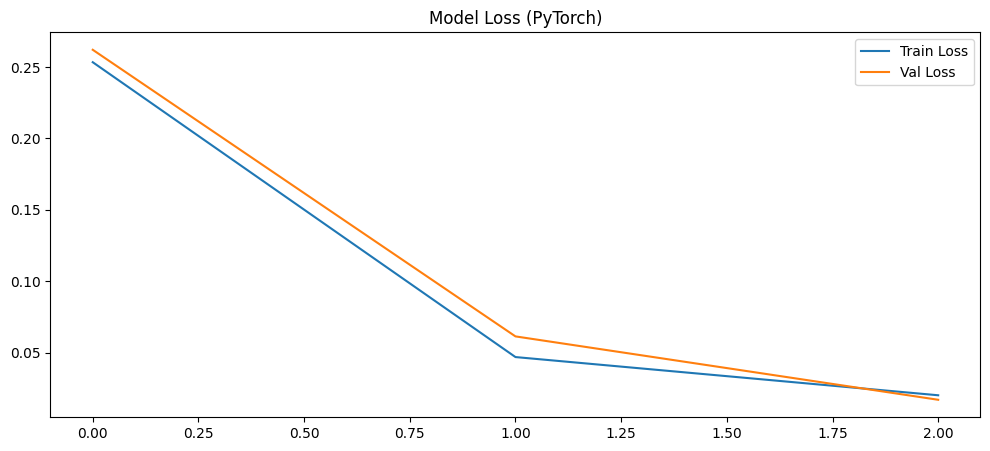

In [35]:
plt.figure(figsize=(12, 5))
plt.plot(loss_history['train'], label='Train Loss')
plt.plot(loss_history['val'], label='Val Loss')
plt.title('Model Loss (PyTorch)')
plt.legend()
plt.show()

In [36]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy().flatten())
        all_labels.extend(labels.numpy())

In [37]:
accuracy = accuracy_score(all_labels, all_preds)
print(f"The accuracy of the model is: {accuracy:.4f}")

The accuracy of the model is: 0.9908
